In [ ]:
import sys
from pathlib import Path

# Add project root (PINN/) to Python path
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT))


In [ ]:
from src.model import PINN
from src.losses import pde_loss


In [ ]:
import torch
from src.model import PINN

model = PINN(layers=[3, 64, 64, 64, 1])
model.load_state_dict(torch.load("F:\\PINN\\trained_pinn.pt", map_location="cpu"))
model.eval()

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [ ]:
from src.losses import pde_loss

r_min, r_max = 0.05, 1.0

r_test = r_min + (r_max - r_min) * torch.rand(1000, 1)
z_test = 2.0 * torch.rand(1000, 1)
t_test = 10.0 * torch.rand(1000, 1)

pde_res = pde_loss(model, r_test, z_test, t_test).item()
print("Corrected PDE residual:", pde_res)


Corrected PDE residual: 0.020780246704816818


In [ ]:
from src.losses import surface_stress_free_loss, interface_continuity_loss

r = 0.05 + 0.95 * torch.rand(500, 1)
t = 10.0 * torch.rand(500, 1)

bc_surface = surface_stress_free_loss(model, r, t).item()
bc_interface = interface_continuity_loss(model, r, t).item()

print("Surface BC loss:", bc_surface)
print("Interface BC loss:", bc_interface)


Surface BC loss: 0.0037792958319187164
Interface BC loss: 3.1577691572692856e-08


In [ ]:
torch.save(model.state_dict(), "trained_pinn_final.pt")


In [ ]:
z0 = 0.2
t = torch.linspace(0, 10, 2000).view(-1,1)


In [ ]:
import numpy as np
import torch

# ---- STEP 1: Extract omega (temporal frequency) ----

z0 = 0.2

t = torch.linspace(0, 10, 2000).view(-1, 1)
r = torch.full_like(t, 0.5)
z = torch.full_like(t, z0)

with torch.no_grad():
    u_t = model(torch.cat([r, z, t], dim=1)).numpy().flatten()

fft_t = np.fft.fft(u_t)
freqs_t = np.fft.fftfreq(len(u_t), d=(t[1] - t[0]).item())

idx_t = np.argmax(np.abs(fft_t[1 : len(u_t)//2])) + 1
omega = 2 * np.pi * abs(freqs_t[idx_t])

print("Extracted omega:", omega)


Extracted omega: 0.6280043501046757


In [ ]:
import numpy as np
k_list = []
c_list = []

for r_max in [0.6, 0.8, 1.0]:
    r = torch.linspace(0.05, r_max, 2000).view(-1,1)
    z = torch.full_like(r, z0)
    t0 = torch.zeros_like(r)

    with torch.no_grad():
        u_r = model(torch.cat([r, z, t0], dim=1)).numpy().flatten()

    fft = np.fft.fft(u_r)
    freqs = np.fft.fftfreq(len(u_r), d=(r[1]-r[0]).item())
    idx = np.argmax(np.abs(fft[1:len(u_r)//2])) + 1
    k = 2*np.pi*abs(freqs[idx])

    c = omega / k
    k_list.append(k)
    c_list.append(c)


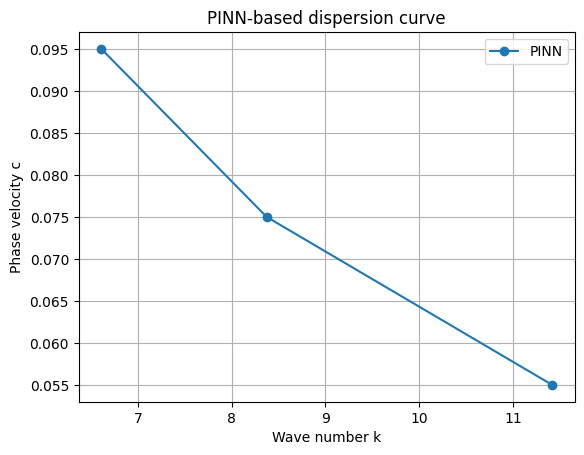

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_list, c_list, 'o-', label="PINN")
plt.xlabel("Wave number k")
plt.ylabel("Phase velocity c")
plt.title("PINN-based dispersion curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np

def analytical_phase_velocity(k):
    """
    Placeholder analytical dispersion.
    Replace this with Eq. (26) from manuscript.
    """
    c0 = 1.0   # reference velocity
    alpha = 0.2  # heterogeneity strength
    return c0 * (1 + alpha * k**2)


In [ ]:
c_analytical = [analytical_phase_velocity(k) for k in k_list]


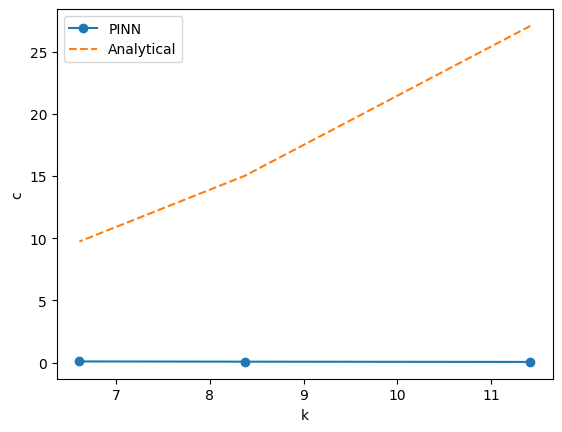

In [ ]:
plt.plot(k_list, c_list, 'o-', label="PINN")
plt.plot(k_list, c_analytical, '--', label="Analytical")
plt.legend()
plt.xlabel("k")
plt.ylabel("c")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.pinn import train_pinn, estimate_k_from_model
from src.analytical import analytical_velocity


omegas = np.linspace(0.5, 4.0, 10)

c_pinn = []
c_ana = []

for w in omegas:

    # ---- Train PINN for this frequency ----
    model = train_pinn(epochs=100, omega=w)

    # ---- Estimate wavenumber ----
    k = estimate_k_from_model(model)

    c_pinn.append(w / k)

    # ---- Analytical velocity ----
    c_ana.append(analytical_velocity(w))


plt.figure(figsize=(7,5))
plt.plot(omegas, c_pinn, "o-", label="PINN")
plt.plot(omegas, c_ana, "s--", label="Analytical")
plt.xlabel("ω")
plt.ylabel("Phase velocity c")
plt.title("Comparison of Dispersion Curves")
plt.grid(True)
plt.legend()
plt.show()
